# EuroSat Image Classification using EfficientNetV2

Hector Becerra  
Juan Terven  
2023

**EfficientNetV2**, introduced in 2021 by researchers Mingxing Tan and Quoc V. Le, is an advanced iteration of the EfficientNet family of convolutional neural network (CNN) architectures, designed to optimize both accuracy and efficiency. Building on the foundation of the original EfficientNet, which systematically scaled up CNNs along width, depth, and resolution dimensions, EfficientNetV2 introduces refinements for faster training and better parameter efficiency. Key innovations include the use of a combination of fused-MBConv and MBConv layers for faster training, progressive learning where training starts with smaller images and gradually increases to larger sizes, and an improved compound scaling method. These enhancements allow EfficientNetV2 to achieve superior performance on image classification tasks with significantly reduced training time and computational cost, making it a powerful choice for real-world applications where resources are a constraint.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import efficientnet_v2_m,EfficientNet_V2_M_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_EfficientNetV2_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = EfficientNet_V2_M_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

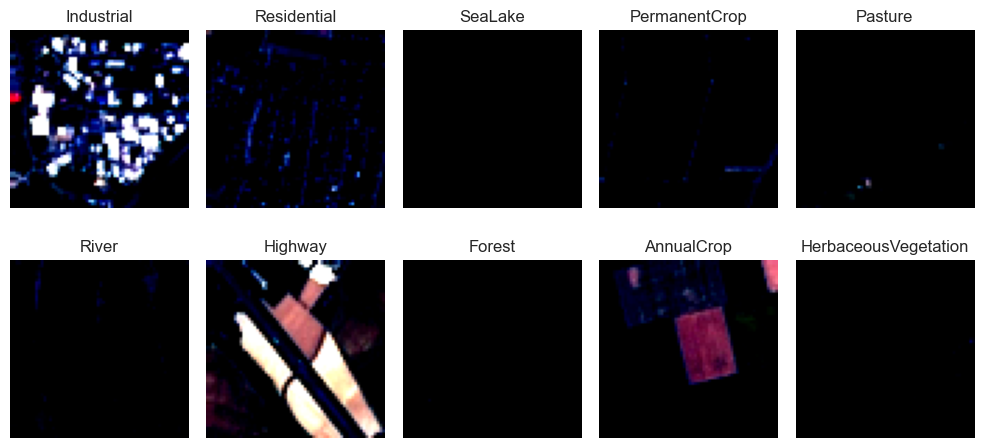

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

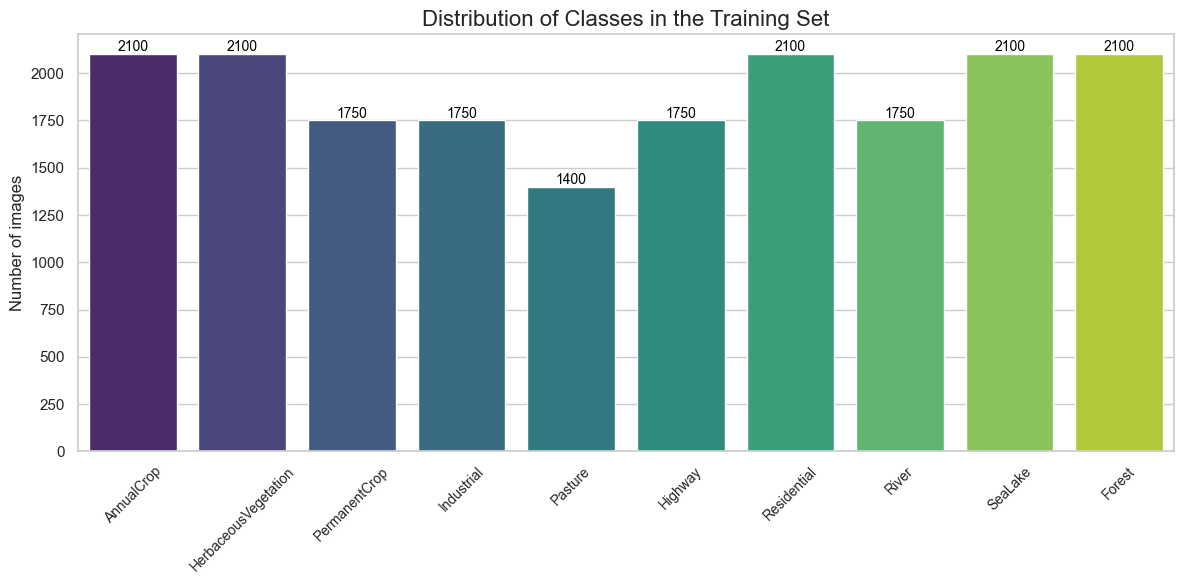

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = efficientnet_v2_m()

# Replace the model head with the number of classes
num_classes = 10
model.classifier[1] = nn.Linear(1280, num_classes) 
model.to(DEVICE)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# Training model from Scratch

In [16]:
project_name = "EuroSAT"
model_name = "EfficientNetV2"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/"

In [17]:
epochs = 200
lr = 0.001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="EfficientNetV2 from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.0907767176628114
Step: 41/296 Loss: 1.7989248752593994
Step: 61/296 Loss: 1.7002585232257843
Step: 81/296 Loss: 1.7141722083091735
Step: 101/296 Loss: 1.6090994834899903
Step: 121/296 Loss: 1.7233638525009156
Step: 141/296 Loss: 1.6438876330852508
Step: 161/296 Loss: 1.5868352711200715
Step: 181/296 Loss: 1.6095844388008118
Step: 201/296 Loss: 1.6034713685512543
Step: 221/296 Loss: 1.5063380300998688
Step: 241/296 Loss: 1.4771273136138916
Step: 261/296 Loss: 1.470014625787735
Step: 281/296 Loss: 1.500364714860916
Validation Loss: 1.3285 Accuracy: 0.4833
Epoch duration: 182.56s

Epoch: 2...
Step: 21/296 Loss: 1.79499694108963
Step: 41/296 Loss: 1.4776619851589203
Step: 61/296 Loss: 1.4316027343273163
Step: 81/296 Loss: 1.380428320169449
Step: 101/296 Loss: 1.3772125840187073
Step: 121/296 Loss: 1.3522556602954865
Step: 141/296 Loss: 1.4462107717990875
Step: 161/296 Loss: 1.42

Step: 41/296 Loss: 0.1904313201084733
Step: 61/296 Loss: 0.28278178311884405
Step: 81/296 Loss: 0.2211225263774395
Step: 101/296 Loss: 0.21643513739109038
Step: 121/296 Loss: 0.21977698467671872
Step: 141/296 Loss: 0.18845677338540553
Step: 161/296 Loss: 0.2033217716962099
Step: 181/296 Loss: 0.22838519234210253
Step: 201/296 Loss: 0.2154145747423172
Step: 221/296 Loss: 0.23698956295847892
Step: 241/296 Loss: 0.2598921608179808
Step: 261/296 Loss: 0.15775151774287224
Step: 281/296 Loss: 0.20258607249706984
Validation Loss: 0.4383 Accuracy: 0.8622
Epoch duration: 183.63s

Epoch: 15...
Step: 21/296 Loss: 0.23212851881980895
Step: 41/296 Loss: 0.15841718800365925
Step: 61/296 Loss: 0.1712681196630001
Step: 81/296 Loss: 0.1771885983645916
Step: 101/296 Loss: 0.22410633638501168
Step: 121/296 Loss: 0.25863008592277764
Step: 141/296 Loss: 0.25511105842888354
Step: 161/296 Loss: 0.1928788587450981
Step: 181/296 Loss: 0.19060049019753933
Step: 201/296 Loss: 0.19907828606665134
Step: 221/296 Lo

Step: 41/296 Loss: 0.1564616745337844
Step: 61/296 Loss: 0.12135786172002554
Step: 81/296 Loss: 0.06486316211521626
Step: 101/296 Loss: 0.09909823341295124
Step: 121/296 Loss: 0.07480782051570714
Step: 141/296 Loss: 0.07497903211042285
Step: 161/296 Loss: 0.0836733288015239
Step: 181/296 Loss: 0.12698012043256313
Step: 201/296 Loss: 0.14574043676257134
Step: 221/296 Loss: 0.192068537697196
Step: 241/296 Loss: 0.11803960325196386
Step: 261/296 Loss: 0.10817381562665104
Step: 281/296 Loss: 0.10728122340515256
Validation Loss: 0.4134 Accuracy: 0.9009
Epoch duration: 180.44s

Epoch: 28...
Step: 21/296 Loss: 0.12163930153474212
Step: 41/296 Loss: 0.08993925340473652
Step: 61/296 Loss: 0.08354550101794303
Step: 81/296 Loss: 0.06278634482296183
Step: 101/296 Loss: 0.07138100652955473
Step: 121/296 Loss: 0.07421118970960379
Step: 141/296 Loss: 0.0735386726213619
Step: 161/296 Loss: 0.08726050816476345
Step: 181/296 Loss: 0.07818050216883421
Step: 201/296 Loss: 0.05783704021014273
Step: 221/296

Step: 41/296 Loss: 0.050505402346607296
Step: 61/296 Loss: 0.050160457100719216
Step: 81/296 Loss: 0.07839348029810936
Step: 101/296 Loss: 0.0347355434903875
Step: 121/296 Loss: 0.02702234309981577
Step: 141/296 Loss: 0.06388792342040688
Step: 161/296 Loss: 0.09029227930586785
Step: 181/296 Loss: 0.06461059835273772
Step: 201/296 Loss: 0.05658006996382028
Step: 221/296 Loss: 0.07002499818336219
Step: 241/296 Loss: 0.05296904083807021
Step: 261/296 Loss: 0.05393810919485986
Step: 281/296 Loss: 0.04185668671270833
Validation Loss: 0.3767 Accuracy: 0.9198
Epoch duration: 172.73s

Epoch: 41...
Step: 21/296 Loss: 0.04505741896573454
Step: 41/296 Loss: 0.02050367183983326
Step: 61/296 Loss: 0.023755429562879727
Step: 81/296 Loss: 0.019688539364142343
Step: 101/296 Loss: 0.04725877811433747
Step: 121/296 Loss: 0.03822703223559074
Step: 141/296 Loss: 0.01658859821909573
Step: 161/296 Loss: 0.014218962017912418
Step: 181/296 Loss: 0.04507702735136263
Step: 201/296 Loss: 0.04529864053474739
Step

## Save model

In [18]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EfficientNetV2_lr1e-3.pth


In [19]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

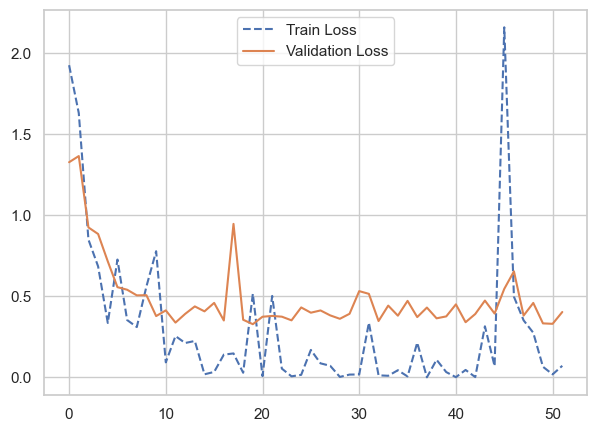

In [20]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [21]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [17]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EfficientNetV2.pth


<All keys matched successfully>

In [18]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.921     0.893     0.907       300
              Forest      1.000     0.923     0.960       300
HerbaceousVegetation      0.858     0.847     0.852       300
             Highway      0.940     0.884     0.911       250
          Industrial      0.957     0.896     0.926       250
             Pasture      0.917     0.830     0.871       200
       PermanentCrop      0.658     0.908     0.763       250
         Residential      0.986     0.947     0.966       300
               River      0.932     0.932     0.932       250
             SeaLake      0.980     0.990     0.985       300

            accuracy                          0.908      2700
           macro avg      0.915     0.905     0.907      2700
        weighted avg      0.918     0.908     0.911      2700



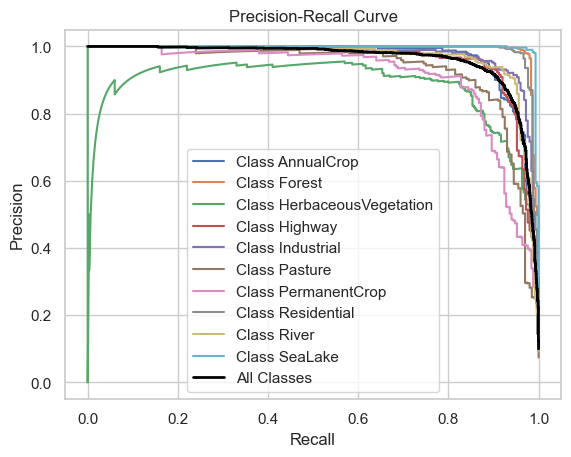

In [23]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [24]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁█▂▂▁▁
val_accuracy,▁▁▄▄▆▆▇▇▇█▇▇▇▅█████████▇███████████▇▇▇██
val_loss,██▅▅▃▂▂▁▂▁▂▂▂▅▁▁▁▁▁▂▂▁▁▂▂▁▁▂▁▂▁▂▁▂▁▂▁▂▁▂
epoch,51
step,15376
train_loss,0.06845
val_accuracy,0.89852
val_loss,0.40377


## Load the precision/recall curve and plot it

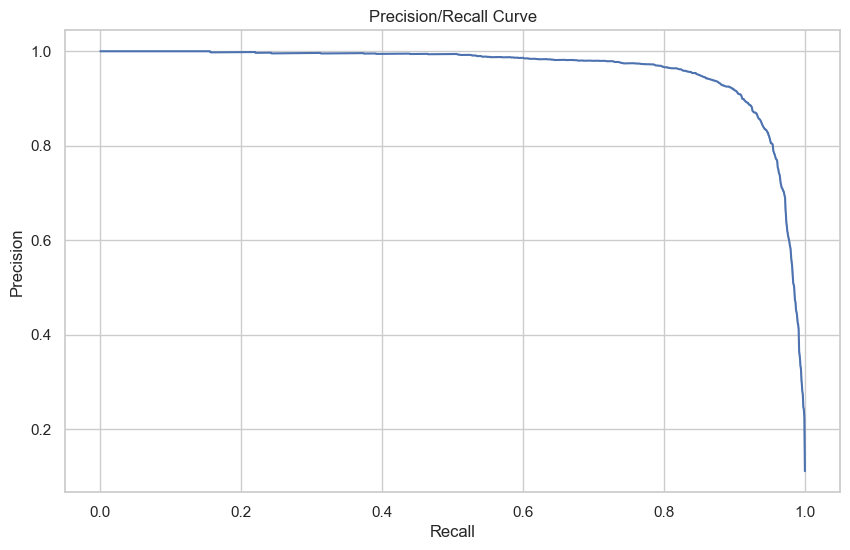

In [25]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [19]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


9

# Now train the model with pre-trained weights

In [20]:
# Use pretrained model
model2 = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier[1] = nn.Linear(1280, num_classes) 
model2.to(DEVICE)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Train with pre-trained weights

In [21]:
model_name = "EfficientNetV2-Pretrained"

In [29]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="EfficientNetV2 pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.3940115332603455
Step: 41/296 Loss: 1.9689097464084626
Step: 61/296 Loss: 1.521281898021698
Step: 81/296 Loss: 1.2030462205410004
Step: 101/296 Loss: 0.9143997669219971
Step: 121/296 Loss: 0.7619250774383545
Step: 141/296 Loss: 0.6358784139156342
Step: 161/296 Loss: 0.4998495727777481
Step: 181/296 Loss: 0.5288249403238297
Step: 201/296 Loss: 0.4511735185980797
Step: 221/296 Loss: 0.42427579164505
Step: 241/296 Loss: 0.3583933629095554
Step: 261/296 Loss: 0.4202170021831989
Step: 281/296 Loss: 0.36957386285066607
Validation Loss: 0.2390 Accuracy: 0.9211
Epoch duration: 139.94s

Epoch: 2...
Step: 21/296 Loss: 0.3317461345344782
Step: 41/296 Loss: 0.24928414188325404
Step: 61/296 Loss: 0.2644480623304844
Step: 81/296 Loss: 0.2149610422551632
Step: 101/296 Loss: 0.17936496175825595
Step: 121/296 Loss: 0.20259595643728973
Step: 141/296 Loss: 0.17230248572304846
Step: 161/296 Los

Step: 281/296 Loss: 0.030837861564941706
Validation Loss: 0.0996 Accuracy: 0.9731
Epoch duration: 142.90s

Epoch: 14...
Step: 21/296 Loss: 0.01901459387736395
Step: 41/296 Loss: 0.0036773004481801762
Step: 61/296 Loss: 0.025250523578142746
Step: 81/296 Loss: 0.010864952232805081
Step: 101/296 Loss: 0.013975482819660101
Step: 121/296 Loss: 0.019382174488418967
Step: 141/296 Loss: 0.015649307701096404
Step: 161/296 Loss: 0.045339483077987096
Step: 181/296 Loss: 0.06158366011804901
Step: 201/296 Loss: 0.11271746307611466
Step: 221/296 Loss: 0.06847728514112532
Step: 241/296 Loss: 0.046490647038444875
Step: 261/296 Loss: 0.014617261523380876
Step: 281/296 Loss: 0.031400871771620584
Validation Loss: 0.1161 Accuracy: 0.9717
Epoch duration: 140.62s

Epoch: 15...
Step: 21/296 Loss: 0.03467170724761672
Step: 41/296 Loss: 0.013232767619774677
Step: 61/296 Loss: 0.010156649236159864
Step: 81/296 Loss: 0.025954308557265902
Step: 101/296 Loss: 0.03547636170405895
Step: 121/296 Loss: 0.0040052837954

Step: 221/296 Loss: 0.13017743655946107
Step: 241/296 Loss: 0.022617314140370583
Step: 261/296 Loss: 0.012999423543806187
Step: 281/296 Loss: 0.023594800347927956
Validation Loss: 0.1225 Accuracy: 0.9739
Epoch duration: 147.35s

Epoch: 27...
Step: 21/296 Loss: 0.007067150893999496
Step: 41/296 Loss: 0.015140666061051888
Step: 61/296 Loss: 0.08485900377854705
Step: 81/296 Loss: 0.01577562921011122
Step: 101/296 Loss: 0.004768489041452995
Step: 121/296 Loss: 0.01934854011888092
Step: 141/296 Loss: 0.027075926204634015
Step: 161/296 Loss: 0.02502579757856438
Step: 181/296 Loss: 0.01636550885741599
Step: 201/296 Loss: 0.006982765313296113
Step: 221/296 Loss: 0.02313566792945494
Step: 241/296 Loss: 0.03602186152129434
Step: 261/296 Loss: 0.061049475969048216
Step: 281/296 Loss: 0.008403985736367758
Validation Loss: 0.1797 Accuracy: 0.9509
Epoch duration: 147.05s

Epoch: 28...
Step: 21/296 Loss: 0.10448912101564929
Step: 41/296 Loss: 1.358572883810848
Step: 61/296 Loss: 0.6392543181777001
St

## Save model

In [30]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EfficientNetV2-Pretrained.pth


In [31]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

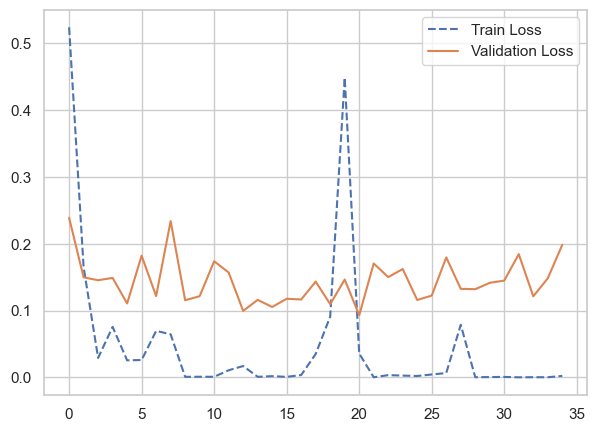

In [32]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [33]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [22]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EfficientNetV2-Pretrained.pth


<All keys matched successfully>

In [23]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.973     0.977     0.975       300
              Forest      0.964     0.990     0.977       300
HerbaceousVegetation      0.957     0.953     0.955       300
             Highway      0.961     0.996     0.978       250
          Industrial      0.984     0.972     0.978       250
             Pasture      0.951     0.980     0.966       200
       PermanentCrop      0.956     0.952     0.954       250
         Residential      0.984     1.000     0.992       300
               River      1.000     0.932     0.965       250
             SeaLake      1.000     0.977     0.988       300

            accuracy                          0.973      2700
           macro avg      0.973     0.973     0.973      2700
        weighted avg      0.974     0.973     0.973      2700



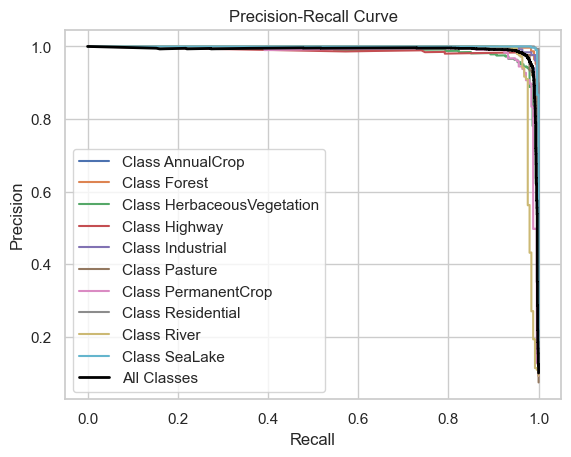

In [35]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [36]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▄▇▂▇▇▆▆█▇▇▇█▇▇▇█▇▇▇██▅▆▆▇▇▇█▇▆
val_loss,█▄▄▄▂▅▂█▂▂▅▄▁▂▂▂▂▃▂▄▁▅▄▄▂▂▅▃▃▃▃▅▂▄▆
epoch,34
step,10344
train_loss,0.06564
val_accuracy,0.9613
val_loss,0.19859


In [24]:
del model2
torch.cuda.empty_cache()
gc.collect()

18